In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from scipy.stats import linregress
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import rankdata

import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
PROTEINS = [
    "5P",
    "NSP1",
    "NSP2",
    "NSP3",
    "NSP4",
    "NSP5",
    "NSP6",
    "NSP7",
    "NSP8",
    "NSP9",
    "NSP10",
    "NSP11",
    "NSP12",
    "NSP13",
    "NSP14",
    "NSP15",
    "NSP16",
    "Spike",
    "NS3",
    "E",
    "M",
    "NS6",
    "NS7a",
    "NS7b",
    "NS8",
    "N",
    "NS9b",
    "NS9c",
    "3P",
    "RNA"
]

ANNOTATION = {
    "5P": "1-265",
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    "NSP6": "10973-11842",
    "NSP7": "11843-12091",
    "NSP8": "12092-12685",
    "NSP9": "12686-13024",
    "NSP10": "13025-13441",
    "NSP11": "13442-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    "NS6": "27202-27387",
    "NS7a": "27394-27759",
    "NS7b": "27756-27887",
    "NS8": "27894-28259",
    "N": "28274-29533",
    "NS9b": "28284-28577",
    "NS9c": "28734-28955",
    "3P": "29534-30331"
}

In [3]:
def read_fasta(path):
    result = ""
    description = ""

    ff = open(path, "r")

    line = next(ff, None)
    while line:
        line = line.rstrip("\n")
        if not line:
            line = next(ff, None)
            continue

        if line.startswith(">"):
            if result:
                yield description, result
            description = line.lstrip(">")
            result = ""
        else:
            result += line

        line = next(ff, None)

    yield description, result
    ff.close()
    
def percent(seq, chr="N"):
    count = 0
    for char in seq:
        if char == chr:
            count += 1
    return count / len(seq)

def region_count(reg, start=None, end=None):
    reg = reg.lstrip("[").rstrip("]").split(", ")
    if not (start is None) and not (end is None):
        reg = [s for s in reg if s and (start <= int(s) <= end)]
    else:
        reg = [s for s in reg if s]
    return len(reg)

In [4]:
# meta description

In [5]:
meta_df = pd.read_csv(
    "../../gisaid/germany_ber_meta.csv",
    sep=",", index_col=0)

rna_df = pd.DataFrame(columns=["strain", "length", "polyA", "percN"])
tqdrator = tqdm.tqdm(read_fasta("../../gisaid/germany_ber.fasta"), total=24778)
for covid, rna in tqdrator:
    length = len(rna)
    perc = percent(rna, "N")
    poly = len(rna) - len(rna.rstrip("A"))
    append_df = pd.DataFrame(
        columns=rna_df.columns.to_list(),
        data=[[
            covid,
            length,
            poly,
            perc
        ]]
    )
    rna_df = pd.concat([rna_df, append_df], ignore_index=True)

rna_df.index = rna_df["strain"]
rna_df = rna_df.drop(columns=["strain"])
meta_df = meta_df.join(rna_df, how="inner")

meta_df["date"] = meta_df.index.str.split("|").str[1]
meta_df["date"] = pd.to_datetime(meta_df["date"], format="%Y-%m-%d")
meta_df = meta_df.sort_values(by=["date"])

meta_df["date"] = meta_df.index.str.split("|").str[1]
meta_df["date"] = pd.to_datetime(meta_df["date"], format="%Y-%m-%d")
meta_df = meta_df.sort_values(by=["date"])

meta_df = meta_df.loc[meta_df["date"].astype("str").apply(lambda dt: len(dt.split("-"))) == 3]
meta_df["year"] = meta_df["date"].astype("str").str.split("-").str[0].astype("int")
meta_df["month"] = meta_df["date"].astype("str").str.split("-").str[1].astype("int")
meta_df["day"] = meta_df["date"].astype("str").str.split("-").str[2].astype("int")
meta_df["days"] = meta_df["day"] + meta_df["month"] * 30 + meta_df["year"] * 365
start = int(meta_df.iloc[0]["days"])
meta_df["days"] -= start
meta_df = meta_df.drop(columns=["year", "month", "day"])

28420it [02:16, 207.73it/s]                           


In [6]:
df = meta_df.loc[
    (~meta_df["scorpio_call"].isna()) & \
    (meta_df["percN"] == 0.) & \
    (meta_df["length"] > 29000)
]

STRAINS = []
df["strain"] = df.index
STRAINS = df["strain"].to_list()
START = meta_df.iloc[0]["date"]

<ipython-input-6-a04314270676>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["strain"] = df.index


In [7]:
meta_df = meta_df.loc[STRAINS]

In [8]:
meta_df.loc[:, "group"] = "first"
meta_df.loc[meta_df["scorpio_call"].str.contains("micron"), "group"] = "second"

In [9]:
# alignment

In [10]:
from Bio import SeqIO
from Bio.Align.Applications import MafftCommandline
import tqdm

In [11]:
import re
import io


def find_all(seq, ref):
    return [m.start() for m in re.finditer(seq, ref)]

def forward(x, aln):
    x += 1
    nucl_num = 0
    for j in range(len(aln)):
        if aln[j] != "-":
            nucl_num += 1
    
        if nucl_num == x:
            return j
    
    return nucl_num
        
def backward(x, aln):
    nucl_num = 0
    for j in range(x):
        if aln[j] != "-":
            nucl_num += 1
    
    return nucl_num

        
def reverse(seq):
    result = ""
    for char in seq[::-1]:
        if char == "A":
            result += "T"
        if char == "T":
            result += "A"
        if char == "G":
            result += "C"
        if char == "C":
            result += "G"
    return result

def uremove(seq):
    result = ""
    for char in seq:
        if char == "U":
            result += "T"
        else:
            result += char
    return result

In [12]:
def align(seq1, seq2, path=None):
    if not path:
        path = ".align.fasta"

    alnf = open(path, "w")
    alnf.write(">" + seq1.description + "\n")
    alnf.write(str(seq1.seq) + "\n")
    alnf.write(">" + seq2.description + "\n")
    alnf.write(str(seq2.seq) + "\n")
    alnf.close()

    mafft_cline = MafftCommandline(input=path)
    stdout, stderr = mafft_cline()

    outf = open(path, "w")
    outf.write(stdout)
    outf.close()

In [13]:
def parallel(ref, rnas, path):
    for rna in rnas:
        name = str(rna.description).replace("/", "+").replace("|", "%")
        align(ref, rna, path=path.lstrip("/") + name + ".fasta")

In [331]:
from multiprocessing import Process

In [333]:
wuhan = next(SeqIO.parse("../../gisaid/wuhan.fasta", "fasta"))
reader = SeqIO.parse("../../gisaid/germany_ber_selected.fasta", "fasta")
procnum = 55

rnas = [rna for rna in reader]
processes = []
batch = len(rnas) // procnum
for i in range(procnum):
    start = batch * i
    end = batch * (i + 1)
    if i == procnum - 1:
        end = len(rnas)

    proc = Process(target=parallel, args=(
        wuhan,
        rnas[start:end],
        "../../results/aligns/germany_ber_selected/"
    ))
    proc.start()
    processes.append(proc)
    
for i in range(len(processes)):
    processes[i].join()

In [336]:
# hsa-let-7b-5p, MIMAT0000063
# hsa-miR-200c-3p, MIMAT0000617

In [65]:
import pandas as pd

In [66]:
mimat = "MIMAT0000063"
# mimat = "MIMAT0000617"
miRBase = pd.read_csv("/home/dude/huge/bulk/miRBase/miRBase_22.1.tsv", sep="\t")

In [67]:
ls = int(miRBase.loc[miRBase["MIMAT"] == mimat]["Local start"].values[0])
seq = str(miRBase.loc[miRBase["MIMAT"] == mimat]["Sequence"].values[0])
seed = seq[ls:ls + 6]

In [68]:
seed = reverse(uremove(seed))

In [69]:
seed

'TACCTC'

In [70]:
# alignment analysis

In [71]:
from Bio import AlignIO

In [74]:
start, end = map(lambda x: int(x) - 1, ANNOTATION["NSP4"].split("-"))
# start, end = map(lambda x: int(x) - 1, ANNOTATION["NSP12"].split("-"))

binds = {}
for name, row in tqdm.tqdm(meta_df.iterrows(), total=len(meta_df)):
    name = str(name).replace("/", "+").replace("|", "%")
    align = AlignIO.read(
        f"../../results/aligns/germany_ber_selected/{name}.fasta",
        "fasta"
    )
    
    wuhan = str(align[0].seq).replace("-", "").upper()
    wuhan_ = str(align[0].seq).upper()

    rna = str(align[1].seq).replace("-", "").upper()
    rna_ = str(align[1].seq).upper()
    
    bindpos = find_all(seed, rna)
    for pos in bindpos:
        rp = pos
        pos = forward(pos, rna_)
        pos = backward(pos, wuhan_)
        wp = pos
        

        if (pos < start) or (pos + 6 > end):
            continue
        
        if not pos in binds:
            binds[pos] = [0, 0, 0]
        
        if row["group"] == "first":
            binds[pos][0] += 1
        elif row["scorpio_call"] == "Omicron (BA.2-like)":
            binds[pos][1] += 1
        else:
            binds[pos][2] += 1

100%|██████████| 3755/3755 [01:36<00:00, 39.02it/s]


In [75]:
print(binds)

{9860: [1691, 15, 1172]}


In [77]:
position = 9860
# position = 15592
early = []
omicron = []
omicron2 = []

for name, row in tqdm.tqdm(meta_df.iterrows(), total=len(meta_df)):
    name = str(name).replace("/", "+").replace("|", "%")
    align = AlignIO.read(
        f"../../results/aligns/germany_ber_selected/{name}.fasta",
        "fasta"
    )
    
    wuhan = str(align[0].seq).replace("-", "").upper()
    wuhan_ = str(align[0].seq).upper()

    rna = str(align[1].seq).replace("-", "").upper()
    rna_ = str(align[1].seq).upper()
    
    pos = forward(position, wuhan_)
    pos = backward(pos, rna_)
    reg = rna[pos - 3:pos + 6 + 3]
    
    if row["group"] == "first":
        early.append(reg)
    elif row["scorpio_call"] == "Omicron (BA.2-like)":
        omicron2.append(reg)
    else:
        omicron.append(reg)

100%|██████████| 3755/3755 [00:27<00:00, 135.56it/s]


In [78]:
import logomaker as lm

TACCTC
0 1691
          A       C       T
pos                        
0       0.0     0.0  1691.0
1    1691.0     0.0     0.0
2       0.0     0.0  1691.0
3       0.0     0.0  1691.0
4    1691.0     0.0     0.0
5       0.0  1691.0     0.0
6       0.0  1691.0     0.0
7       0.0     0.0  1691.0
8       0.0  1691.0     0.0
9       0.0     2.0  1689.0
10      0.0     0.0  1691.0
11   1691.0     0.0     0.0


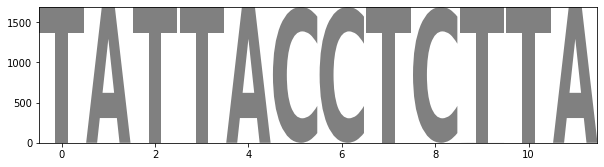

In [79]:
print(seed)
print(len([x for x in early if x == seed]), len(early))
print(lm.alignment_to_matrix(early))
lm.Logo(lm.alignment_to_matrix(early))

TACCTC
0 1177
          A       C       T
pos                        
0       0.0     0.0  1177.0
1    1177.0     0.0     0.0
2       0.0     0.0  1177.0
3       0.0     0.0  1177.0
4    1177.0     0.0     0.0
5       0.0  1177.0     0.0
6       0.0  1177.0     0.0
7       0.0     0.0  1177.0
8       0.0  1172.0     5.0
9       0.0     0.0  1177.0
10      0.0     0.0  1177.0
11   1177.0     0.0     0.0


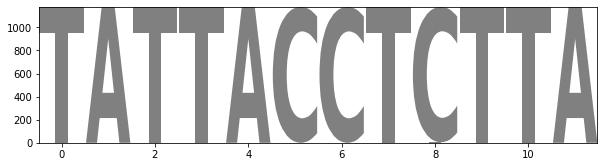

In [80]:
print(seed)
print(len([x for x in omicron if x == seed]), len(omicron))
print(lm.alignment_to_matrix(omicron))
lm.Logo(lm.alignment_to_matrix(omicron))

TACCTC
0 887
         A      C      T
pos                     
0      0.0    0.0  887.0
1    887.0    0.0    0.0
2      0.0    0.0  887.0
3      0.0    0.0  887.0
4    887.0    0.0    0.0
5      0.0  887.0    0.0
6      0.0  887.0    0.0
7      0.0    0.0  887.0
8      0.0   15.0  872.0
9      0.0    0.0  887.0
10     0.0    0.0  887.0
11   887.0    0.0    0.0


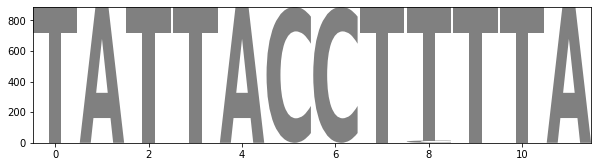

In [81]:
print(seed)
print(len([x for x in omicron2 if x == seed]), len(omicron2))
print(lm.alignment_to_matrix(omicron2))
lm.Logo(lm.alignment_to_matrix(omicron2))

In [85]:
# aminoacid mutation

In [86]:
from Bio import Seq

In [92]:
ref = str(align[0].seq).replace("-", "")

In [100]:
start, end = map(lambda x: int(x) - 1, ANNOTATION["NSP4"].split("-"))
local_start = position - start

In [101]:
ref_region = str(ref[start:end + 1])
mut_region = ref_region[:local_start] + "t" + ref_region[local_start + 1:]

print(str(Seq.translate(ref_region))[local_start // 3])
print(str(Seq.translate(mut_region))[local_start // 3])

L
L


In [106]:
print(local_start % 3)
print(Seq.translate("CTT"))

1
L
